In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np

drive.mount('/content/drive')
os.chdir("drive/My Drive/winequality")
files = "winequality-red.csv" 


Mounted at /content/drive


In [2]:
content = []
with open(files) as f: 
  for line in f:
    line = re.sub("(\n)","",line)
    content.append(line.split(';'))

In [3]:
red_wine_df = pd.DataFrame(content, columns = ["fixed acidity","volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide","density","pH","sulphates","alcohol","quality"])
red_wine_df.drop([0], inplace = True)

y = red_wine_df['quality']
x = red_wine_df[["fixed acidity","volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide","density","pH","sulphates","alcohol"]]

In [4]:
red_wine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599 entries, 1 to 1599
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   fixed acidity         1599 non-null   object
 1   volatile acidity      1599 non-null   object
 2   citric acid           1599 non-null   object
 3   residual sugar        1599 non-null   object
 4   chlorides             1599 non-null   object
 5   free sulfur dioxide   1599 non-null   object
 6   total sulfur dioxide  1599 non-null   object
 7   density               1599 non-null   object
 8   pH                    1599 non-null   object
 9   sulphates             1599 non-null   object
 10  alcohol               1599 non-null   object
 11  quality               1599 non-null   object
dtypes: object(12)
memory usage: 162.4+ KB


**Linear Model**

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import numpy as np

In [6]:
size = [0.5,0.4,0.3,0.2,0.1]
yvalues_test = {}; intercept = {}; predictions = {}; coeff = {}; xvalues_test = {}; rmse = {}
lr_model = LinearRegression()

for i in range(len(size)):
  current = size[i]
  x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = current)
  lr_model.fit(x_train,y_train)

  w = lr_model.coef_; b = lr_model.intercept_; coeff[current] = w; intercept[current] = b
  #predict output based on this model
  predictions[current] = lr_model.predict(x_test)
  xvalues_test[current] = x_test
  yvalues_test[current] = y_test


In [7]:
predictions[0.2]

array([6.49549652, 6.7086593 , 5.76759541, 6.73623844, 5.41962669,
       5.28617094, 5.52483374, 5.5980086 , 5.38524366, 5.67691169,
       5.7650347 , 5.73043625, 5.66463843, 5.60872329, 5.99335154,
       5.33611533, 4.93678053, 5.06555409, 5.81597508, 6.59808545,
       5.60883253, 6.45775634, 6.19290024, 6.58974464, 5.27940696,
       6.71427282, 4.92875513, 6.03593165, 4.94588071, 6.00986416,
       5.78036902, 4.7989039 , 5.51903913, 6.33876684, 5.94560976,
       4.81597748, 6.51697167, 5.19449171, 6.37204988, 5.30458219,
       5.30515299, 5.67523016, 5.91964749, 5.01389374, 5.55126588,
       5.46128931, 5.30328128, 4.77796332, 5.00643804, 5.14744973,
       4.97463504, 5.4950659 , 5.7944706 , 5.2858009 , 5.34150931,
       6.1252731 , 5.09891623, 6.58594934, 5.41119611, 5.49052868,
       5.46984596, 5.88727175, 5.87341992, 6.35513002, 4.871396  ,
       5.26725015, 5.28984342, 6.87838255, 6.39734321, 5.57120453,
       5.93133721, 5.17781032, 6.54051248, 5.43981471, 5.22264

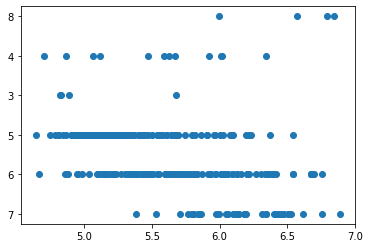

In [8]:
plt.scatter(lr_model.predict(xvalues_test[0.2]), yvalues_test[0.2])

In [9]:
#Testing the performance of a model can be done with Mean absolute error, Mean squared error, Root mean squared error. Can also use accuracy

In [10]:
mse_lr = {}; mae_lr = {}; rmse_lr = {}

for i in range(len(size)):
  current = size[i]
  mse_lr[current] = metrics.mean_squared_error(lr_model.predict(xvalues_test[current]), yvalues_test[current])
  mae_lr[current] = metrics.mean_absolute_error(lr_model.predict(xvalues_test[current]), yvalues_test[current])
  rmse_lr[current] = np.sqrt(metrics.mean_absolute_error(lr_model.predict(xvalues_test[current]), yvalues_test[current]))

In [11]:
mse_lr

{0.1: 0.4876419654428526,
 0.2: 0.48631659034810626,
 0.3: 0.3982143560754511,
 0.4: 0.41949964103327153,
 0.5: 0.45790839135719225}

In [12]:
mae_lr

{0.1: 0.5427935349181396,
 0.2: 0.5256705590308048,
 0.3: 0.49967768640732874,
 0.4: 0.5015779192278146,
 0.5: 0.5179590148221981}

**Two layer Neural Networks**

In [13]:
#Convert data from csvs into arrays
red_wine_data = np.genfromtxt(files, delimiter = ';')

#Removes headers as nan values
red_wine_data = red_wine_data[1:,:] #Numpy arrays are immutable thus can't be deleted. It can only be reassigned.

#Creates quality array from dataset
quality_data = red_wine_data[1:,-1:]

#Creates input array whose values determine the output 
red_wine_input_data = red_wine_data[1:,:-1]

In [33]:
X_input = red_wine_input_data.T
y_output = quality_data.T

N, D_in, H, D_out = 1598, 11, 30, 1

#define activation function
f = lambda x:1/(1+np.exp(-x))  #sigmoid function
f_relu = lambda x: np.maximum(0,x)    #relu function



In [36]:
#create computations

loss_f = []
loss_relu = []
runs = range(2000)
for i in runs:
  w1,w2 = np.random.randn(H, D_in), np.random.randn(D_out,H)
  h1 = 1/(1 + np.exp(-np.dot(w1,X_input).astype(np.float64)))
  h1_relu = f_relu(np.dot(w1, X_input))

  pred = np.dot(w2,h1)
  pred_relu = np.dot(w2, h1_relu)

  loss_relu.append(np.square(pred_relu - y_output).sum())
  loss_f.append(np.square(pred-y_output).sum())

#if there are more hidden layers
#h2 = f(np.dot(w2,h1))

#continue working on this 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


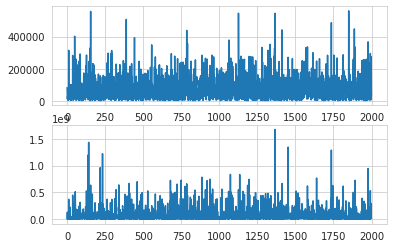

In [39]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2)
ax[0].plot(runs, loss_f)
ax[1].plot(runs, loss_relu)